In [94]:
# imports
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, ViTMAEForPreTraining

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchmetrics.functional import structural_similarity_index_measure as ssim
#import cv2
import os
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from scipy import stats

In [95]:
processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
model.eval()

def get_reconstruction_from_pretrained(images):
   if torch.is_tensor(images):
       return get_reconstruction_from_pretrained_tensor(images)
   else:
       # handle PIL images
       if not isinstance(images, list):
           images = [images]
       rgb_images = [img.convert("RGB") if img.mode != "RGB" else img for img in images]
       return get_reconstruction_from_pretrained_tensor(torch.stack([processor(images=img, return_tensors="pt")["pixel_values"][0] for img in rgb_images]))

def get_reconstruction_from_pretrained_tensor(tensor_images):
   inputs = {"pixel_values": tensor_images}
   
   with torch.no_grad():
       outputs = model(**inputs)
       reconstructions = model.unpatchify(outputs.logits)
   
   reconstructions = torch.sigmoid(reconstructions)
   return reconstructions


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [96]:
# test on single image
def visualize_og_and_reconstruction(image_path):
    image = Image.open(image_path).convert("RGB")
    
    # resize to what the model wants or it throws a fit
    img_tensor = transforms.Compose([
        transforms.Resize((224, 224), antialias=True),
        transforms.ToTensor()
    ])(image).unsqueeze(0).to(device)
    
    reconstruction = get_reconstruction_from_pretrained(img_tensor)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("og image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(reconstruction[0].cpu().numpy().transpose(1, 2, 0))
    plt.title("reconstruction")
    plt.axis("off")
    plt.show()

# visualize_og_and_reconstruction("/home/sonne/Billeder/Memes/bleh.png")

In [97]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform, is_train, defect_types):
        """
        Args:
            root_dir (str): Root directory of MVTec AD dataset
            category (str): Category name (e.g., "bottle", "cable", etc.)
            is_train (bool): If True, load training data, else test data
            transform: transform to be applied on images
        """
        self.root_dir = root_dir
        self.is_train = is_train
        self.transform = transform
        self.defect_types = defect_types
        
        # Set up paths
        if is_train:
            self.image_paths = self._get_image_paths("train/good")
        else:
            self.image_paths = self._get_image_paths("test/good")
            self.image_paths.extend(self._get_defect_image_paths("test"))
            
    def _get_image_paths(self, subset):
        path = os.path.join(self.root_dir, subset)
        if not os.path.exists(path):
            return []
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith((".png", ".jpg"))]
    
    def _get_defect_image_paths(self, subset):
        paths = []
        
        for defect in self.defect_types:
            defect_path = os.path.join(self.root_dir, subset, defect)
            paths.extend([os.path.join(defect_path, f) for f in os.listdir(defect_path)])
        return paths
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        #image = image / 255.0
        # 1 for good; 0 for defect
        label = 1 if "good" in img_path else 0
        return image, label
    
class RandomZoom:
    def __init__(self, zoom_range=(0.8, 1.0), num_augmentations=3):
        """
        Initializes the RandomZoom transformation for augmentation.
        Args:
            zoom_range (tuple): Range for the zoom factor. Values < 1.0 mean zoom-in.
            num_augmentations (int): Number of augmented images to generate per input image.
        """
        self.zoom_range = zoom_range
        self.num_augmentations = num_augmentations

    def __call__(self, img):
        """
        Applies multiple random zoom transformations to the tensor image.
        Args:
            img (torch.Tensor): Input image tensor of shape [C, H, W].
        Returns:
            list: A list of augmented image tensors.
        """
        augmented_images = []
        
        # Get dimensions from tensor shape
        c, h, w = img.shape
        
        # Add batch dimension for F.interpolate
        img = img.unsqueeze(0)
        
        for _ in range(self.num_augmentations):
            # Randomly select a zoom factor
            zoom_factor = random.uniform(*self.zoom_range)
            
            # Calculate new dimensions for cropping
            crop_height = int(h * zoom_factor)
            crop_width = int(w * zoom_factor)
            
            # Ensure dimensions are valid
            crop_height = min(crop_height, h)
            crop_width = min(crop_width, w)
            
            # Calculate random crop position
            top = random.randint(0, h - crop_height) if h > crop_height else 0
            left = random.randint(0, w - crop_width) if w > crop_width else 0
            
            # Perform crop
            cropped = img[:, :, top:top+crop_height, left:left+crop_width]
            
            # Resize back to original dimensions
            resized = F.interpolate(cropped, size=(h, w), mode="bilinear", align_corners=False)
            
            # Remove batch dimension and append to results
            augmented_images.append(resized.squeeze(0))
            
        return augmented_images

class ZoomedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, zoom_range=(0.6, 0.9), num_augmentations=10):
        """
        Initializes the ZoomedDataset for data augmentation.
        Args:
            dataset (Dataset): Source dataset to wrap.
            transform (callable, optional): Additional transformations to apply.
            zoom_range (tuple): Range for the random zoom factor.
            num_augmentations (int): Number of augmented images per original image.
        """
        self.dataset = dataset
        self.transform = transform
        self.random_zoom = RandomZoom(zoom_range, num_augmentations)

    def __len__(self):
        return len(self.dataset) * self.random_zoom.num_augmentations

    def __getitem__(self, idx):
        """
        Returns an augmented image and its corresponding label.
        Args:
            idx (int): Index of the augmented image in the dataset.
        Returns:
            (torch.Tensor, int): The augmented image and its label.
        """
        # Determine the original image index and augmentation index
        original_idx = idx // self.random_zoom.num_augmentations
        augmentation_idx = idx % self.random_zoom.num_augmentations

        # Get the original image and label
        img, label = self.dataset[original_idx]
        
        # Generate augmented images
        augmented_images = self.random_zoom(img)
        
        # Select the appropriate augmented image
        img_augmented = augmented_images[augmentation_idx]
        
        return img_augmented, label

In [98]:
# Run data through pretrained model and get reconstruction errors
def get_anomaly_value(test_loader, device="cpu"):
    model.eval()
    errors = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            data = batch_data.to(device)
            reconstructed = get_reconstruction_from_pretrained(data)
            error = torch.nn.MSELoss()(reconstructed, data)
            errors.append(error)

    seperator = sum(errors) / len(errors)
    return seperator

def get_predictions(loader, threshold, device="cpu", return_all_images=False):

    model.eval()
    all_images = []
    predictions = []
    true_labels = []
    reconstruction_errors = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed = get_reconstruction_from_pretrained(images)
            if return_all_images:
                all_images.extend(images.cpu())

            for (i, r, l) in zip(images, reconstructed, labels):
                
                error = torch.nn.MSELoss()(r, i)
                #error = 1 - ssim(i.unsqueeze(0), r.unsqueeze(0), data_range=1.0)
                reconstruction_errors.append(error.cpu().numpy())
            
                # Classify as anomaly if reconstruction error > threshold
                pred = (error <= threshold).float().cpu().numpy()
                predictions.append(pred)
            
                true_labels.append(l.cpu().numpy())
    
    # Convert lists to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    reconstruction_errors = np.array(reconstruction_errors)
    if return_all_images:
        return all_images, predictions, true_labels, reconstruction_errors
    return predictions, true_labels, reconstruction_errors

def plot_anomaly_scores(recon_errors, true_labels, threshold, figsize=(12, 6), title="Anomaly Scores (single threshold)"):
    plt.figure(figsize=figsize)
    
    errors = np.array(recon_errors)
    labels = np.array(true_labels)
    # Convert threshold to numpy if it's a tensor, otherwise use as is
    if torch.is_tensor(threshold):
        threshold = threshold.cpu().numpy()
    else:
        threshold = np.float32(threshold)
    predictions = errors <= threshold
    
    for idx, (error, label, pred) in enumerate(zip(errors, labels, predictions)):
        marker = "o" if label == 1 else "x"
        color = "#2ecc71" if label == pred else "#e74c3c"
        plt.scatter(idx, error, c=color, marker=marker, s=100)
    
    plt.axhline(y=threshold, color="#3498db", linestyle="--", 
                label=f"Threshold: {threshold:.4f}")
    
    plt.grid(True, alpha=0.3)
    plt.xlabel("Sample Index")
    plt.ylabel("Reconstruction Error")
    plt.title(title)
    
    plt.scatter([], [], c="k", marker="o", label="Normal")
    plt.scatter([], [], c="k", marker="x", label="Anomaly")
    plt.scatter([], [], c="#2ecc71", marker="s", label="Correct")
    plt.scatter([], [], c="#e74c3c", marker="s", label="Wrong")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return plt

In [99]:
# Path to "good" training images for bottle category
path = "wood/"
subcategories = ["color", "combined", "hole", "liquid", "scratch"]

transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                       std=[0.229, 0.224, 0.225])
])

train_dataset = MVTecDataset(path, transform, is_train=True, defect_types=subcategories)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MVTecDataset(path, transform, is_train=False, defect_types=subcategories)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

zoom_dataset = ZoomedDataset(train_dataset, transform, num_augmentations=3)
zoom_train_loader = DataLoader(zoom_dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# whoops forgot to finetune

In [100]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 200 

model.train()  # Set model to training mode
for epoch in range(epochs):
    running_loss = 0.0
    
    # Use tqdm for progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
        for images, _ in pbar:
            images = images.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(pixel_values=images).logits
            reconstructions = model.unpatchify(outputs)
            reconstructions = torch.sigmoid(reconstructions)
            
            # Calculate loss
            loss = criterion(reconstructions, images)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss/len(train_loader))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Fine-tuning completed.")

Epoch 1/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.103] 


Epoch 1/200, Loss: 0.1029


Epoch 2/200: 100%|██████████| 16/16 [00:10<00:00,  1.49batch/s, loss=0.0622]


Epoch 2/200, Loss: 0.0622


Epoch 3/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0602]


Epoch 3/200, Loss: 0.0602


Epoch 4/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.059] 


Epoch 4/200, Loss: 0.0590


Epoch 5/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0586]


Epoch 5/200, Loss: 0.0586


Epoch 6/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0577]


Epoch 6/200, Loss: 0.0577


Epoch 7/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0576]


Epoch 7/200, Loss: 0.0576


Epoch 8/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0579]


Epoch 8/200, Loss: 0.0579


Epoch 9/200: 100%|██████████| 16/16 [00:10<00:00,  1.49batch/s, loss=0.0571]


Epoch 9/200, Loss: 0.0571


Epoch 10/200: 100%|██████████| 16/16 [00:10<00:00,  1.45batch/s, loss=0.0573]


Epoch 10/200, Loss: 0.0573


Epoch 11/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0568]


Epoch 11/200, Loss: 0.0568


Epoch 12/200: 100%|██████████| 16/16 [00:11<00:00,  1.43batch/s, loss=0.0576]


Epoch 12/200, Loss: 0.0576


Epoch 13/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0568]


Epoch 13/200, Loss: 0.0568


Epoch 14/200: 100%|██████████| 16/16 [00:10<00:00,  1.50batch/s, loss=0.0566]


Epoch 14/200, Loss: 0.0566


Epoch 15/200: 100%|██████████| 16/16 [00:10<00:00,  1.50batch/s, loss=0.0568]


Epoch 15/200, Loss: 0.0568


Epoch 16/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0563]


Epoch 16/200, Loss: 0.0563


Epoch 17/200: 100%|██████████| 16/16 [00:10<00:00,  1.49batch/s, loss=0.0565]


Epoch 17/200, Loss: 0.0565


Epoch 18/200: 100%|██████████| 16/16 [00:11<00:00,  1.44batch/s, loss=0.0561]


Epoch 18/200, Loss: 0.0561


Epoch 19/200: 100%|██████████| 16/16 [00:11<00:00,  1.44batch/s, loss=0.0566]


Epoch 19/200, Loss: 0.0566


Epoch 20/200: 100%|██████████| 16/16 [00:11<00:00,  1.44batch/s, loss=0.0563]


Epoch 20/200, Loss: 0.0563


Epoch 21/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0564]


Epoch 21/200, Loss: 0.0564


Epoch 22/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0559]


Epoch 22/200, Loss: 0.0559


Epoch 23/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0563]


Epoch 23/200, Loss: 0.0563


Epoch 24/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0562]


Epoch 24/200, Loss: 0.0562


Epoch 25/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0558]


Epoch 25/200, Loss: 0.0558


Epoch 26/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0557]


Epoch 26/200, Loss: 0.0557


Epoch 27/200: 100%|██████████| 16/16 [00:11<00:00,  1.43batch/s, loss=0.0557]


Epoch 27/200, Loss: 0.0557


Epoch 28/200: 100%|██████████| 16/16 [00:11<00:00,  1.43batch/s, loss=0.0557]


Epoch 28/200, Loss: 0.0557


Epoch 29/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.056] 


Epoch 29/200, Loss: 0.0560


Epoch 30/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0557]


Epoch 30/200, Loss: 0.0557


Epoch 31/200: 100%|██████████| 16/16 [00:10<00:00,  1.45batch/s, loss=0.0558]


Epoch 31/200, Loss: 0.0558


Epoch 32/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.056] 


Epoch 32/200, Loss: 0.0560


Epoch 33/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0555]


Epoch 33/200, Loss: 0.0555


Epoch 34/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0553]


Epoch 34/200, Loss: 0.0553


Epoch 35/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0552]


Epoch 35/200, Loss: 0.0552


Epoch 36/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0553]


Epoch 36/200, Loss: 0.0553


Epoch 37/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0552]


Epoch 37/200, Loss: 0.0552


Epoch 38/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0556]


Epoch 38/200, Loss: 0.0556


Epoch 39/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.055] 


Epoch 39/200, Loss: 0.0550


Epoch 40/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0552]


Epoch 40/200, Loss: 0.0552


Epoch 41/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0554]


Epoch 41/200, Loss: 0.0554


Epoch 42/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0549]


Epoch 42/200, Loss: 0.0549


Epoch 43/200: 100%|██████████| 16/16 [00:10<00:00,  1.49batch/s, loss=0.0549]


Epoch 43/200, Loss: 0.0549


Epoch 44/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0552]


Epoch 44/200, Loss: 0.0552


Epoch 45/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0551]


Epoch 45/200, Loss: 0.0551


Epoch 46/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.055] 


Epoch 46/200, Loss: 0.0550


Epoch 47/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0556]


Epoch 47/200, Loss: 0.0556


Epoch 48/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0549]


Epoch 48/200, Loss: 0.0549


Epoch 49/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.055] 


Epoch 49/200, Loss: 0.0550


Epoch 50/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0549]


Epoch 50/200, Loss: 0.0549


Epoch 51/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.055] 


Epoch 51/200, Loss: 0.0550


Epoch 52/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0545]


Epoch 52/200, Loss: 0.0545


Epoch 53/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0552]


Epoch 53/200, Loss: 0.0552


Epoch 54/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0554]


Epoch 54/200, Loss: 0.0554


Epoch 55/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0549]


Epoch 55/200, Loss: 0.0549


Epoch 56/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.055] 


Epoch 56/200, Loss: 0.0550


Epoch 57/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.055] 


Epoch 57/200, Loss: 0.0550


Epoch 58/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0545]


Epoch 58/200, Loss: 0.0545


Epoch 59/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0542]


Epoch 59/200, Loss: 0.0542


Epoch 60/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0547]


Epoch 60/200, Loss: 0.0547


Epoch 61/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0546]


Epoch 61/200, Loss: 0.0546


Epoch 62/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0544]


Epoch 62/200, Loss: 0.0544


Epoch 63/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0545]


Epoch 63/200, Loss: 0.0545


Epoch 64/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0543]


Epoch 64/200, Loss: 0.0543


Epoch 65/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0542]


Epoch 65/200, Loss: 0.0542


Epoch 66/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0546]


Epoch 66/200, Loss: 0.0546


Epoch 67/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0541]


Epoch 67/200, Loss: 0.0541


Epoch 68/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0546]


Epoch 68/200, Loss: 0.0546


Epoch 69/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0544]


Epoch 69/200, Loss: 0.0544


Epoch 70/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0541]


Epoch 70/200, Loss: 0.0541


Epoch 71/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.054] 


Epoch 71/200, Loss: 0.0540


Epoch 72/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0546]


Epoch 72/200, Loss: 0.0546


Epoch 73/200: 100%|██████████| 16/16 [00:11<00:00,  1.44batch/s, loss=0.0545]


Epoch 73/200, Loss: 0.0545


Epoch 74/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0541]


Epoch 74/200, Loss: 0.0541


Epoch 75/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.054] 


Epoch 75/200, Loss: 0.0540


Epoch 76/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0548]


Epoch 76/200, Loss: 0.0548


Epoch 77/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0541]


Epoch 77/200, Loss: 0.0541


Epoch 78/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0539]


Epoch 78/200, Loss: 0.0539


Epoch 79/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0536]


Epoch 79/200, Loss: 0.0536


Epoch 80/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0541]


Epoch 80/200, Loss: 0.0541


Epoch 81/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0539]


Epoch 81/200, Loss: 0.0539


Epoch 82/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0539]


Epoch 82/200, Loss: 0.0539


Epoch 83/200: 100%|██████████| 16/16 [00:10<00:00,  1.45batch/s, loss=0.0538]


Epoch 83/200, Loss: 0.0538


Epoch 84/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0546]


Epoch 84/200, Loss: 0.0546


Epoch 85/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.054] 


Epoch 85/200, Loss: 0.0540


Epoch 86/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0534]


Epoch 86/200, Loss: 0.0534


Epoch 87/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0537]


Epoch 87/200, Loss: 0.0537


Epoch 88/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0538]


Epoch 88/200, Loss: 0.0538


Epoch 89/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0535]


Epoch 89/200, Loss: 0.0535


Epoch 90/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0541]


Epoch 90/200, Loss: 0.0541


Epoch 91/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0541]


Epoch 91/200, Loss: 0.0541


Epoch 92/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0534]


Epoch 92/200, Loss: 0.0534


Epoch 93/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0536]


Epoch 93/200, Loss: 0.0536


Epoch 94/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0537]


Epoch 94/200, Loss: 0.0537


Epoch 95/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0537]


Epoch 95/200, Loss: 0.0537


Epoch 96/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0534]


Epoch 96/200, Loss: 0.0534


Epoch 97/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0535]


Epoch 97/200, Loss: 0.0535


Epoch 98/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0533]


Epoch 98/200, Loss: 0.0533


Epoch 99/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0535]


Epoch 99/200, Loss: 0.0535


Epoch 100/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0534]


Epoch 100/200, Loss: 0.0534


Epoch 101/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.053] 


Epoch 101/200, Loss: 0.0530


Epoch 102/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0531]


Epoch 102/200, Loss: 0.0531


Epoch 103/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0532]


Epoch 103/200, Loss: 0.0532


Epoch 104/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0533]


Epoch 104/200, Loss: 0.0533


Epoch 105/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0535]


Epoch 105/200, Loss: 0.0535


Epoch 106/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0529]


Epoch 106/200, Loss: 0.0529


Epoch 107/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0531]


Epoch 107/200, Loss: 0.0531


Epoch 108/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0533]


Epoch 108/200, Loss: 0.0533


Epoch 109/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0534]


Epoch 109/200, Loss: 0.0534


Epoch 110/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0533]


Epoch 110/200, Loss: 0.0533


Epoch 111/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0526]


Epoch 111/200, Loss: 0.0526


Epoch 112/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0534]


Epoch 112/200, Loss: 0.0534


Epoch 113/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0526]


Epoch 113/200, Loss: 0.0526


Epoch 114/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0532]


Epoch 114/200, Loss: 0.0532


Epoch 115/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0528]


Epoch 115/200, Loss: 0.0528


Epoch 116/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.053] 


Epoch 116/200, Loss: 0.0530


Epoch 117/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0527]


Epoch 117/200, Loss: 0.0527


Epoch 118/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0531]


Epoch 118/200, Loss: 0.0531


Epoch 119/200: 100%|██████████| 16/16 [00:11<00:00,  1.44batch/s, loss=0.0531]


Epoch 119/200, Loss: 0.0531


Epoch 120/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0531]


Epoch 120/200, Loss: 0.0531


Epoch 121/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.053] 


Epoch 121/200, Loss: 0.0530


Epoch 122/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.053] 


Epoch 122/200, Loss: 0.0530


Epoch 123/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0528]


Epoch 123/200, Loss: 0.0528


Epoch 124/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0528]


Epoch 124/200, Loss: 0.0528


Epoch 125/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0528]


Epoch 125/200, Loss: 0.0528


Epoch 126/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0526]


Epoch 126/200, Loss: 0.0526


Epoch 127/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0527]


Epoch 127/200, Loss: 0.0527


Epoch 128/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0526]


Epoch 128/200, Loss: 0.0526


Epoch 129/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0528]


Epoch 129/200, Loss: 0.0528


Epoch 130/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0526]


Epoch 130/200, Loss: 0.0526


Epoch 131/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0533]


Epoch 131/200, Loss: 0.0533


Epoch 132/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0527]


Epoch 132/200, Loss: 0.0527


Epoch 133/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0527]


Epoch 133/200, Loss: 0.0527


Epoch 134/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0527]


Epoch 134/200, Loss: 0.0527


Epoch 135/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0526]


Epoch 135/200, Loss: 0.0526


Epoch 136/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0523]


Epoch 136/200, Loss: 0.0523


Epoch 137/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0528]


Epoch 137/200, Loss: 0.0528


Epoch 138/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0526]


Epoch 138/200, Loss: 0.0526


Epoch 139/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0528]


Epoch 139/200, Loss: 0.0528


Epoch 140/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0521]


Epoch 140/200, Loss: 0.0521


Epoch 141/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0522]


Epoch 141/200, Loss: 0.0522


Epoch 142/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0523]


Epoch 142/200, Loss: 0.0523


Epoch 143/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0521]


Epoch 143/200, Loss: 0.0521


Epoch 144/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0524]


Epoch 144/200, Loss: 0.0524


Epoch 145/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.052] 


Epoch 145/200, Loss: 0.0520


Epoch 146/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0523]


Epoch 146/200, Loss: 0.0523


Epoch 147/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0527]


Epoch 147/200, Loss: 0.0527


Epoch 148/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0523]


Epoch 148/200, Loss: 0.0523


Epoch 149/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0519]


Epoch 149/200, Loss: 0.0519


Epoch 150/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0525]


Epoch 150/200, Loss: 0.0525


Epoch 151/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0523]


Epoch 151/200, Loss: 0.0523


Epoch 152/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0523]


Epoch 152/200, Loss: 0.0523


Epoch 153/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0516]


Epoch 153/200, Loss: 0.0516


Epoch 154/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0521]


Epoch 154/200, Loss: 0.0521


Epoch 155/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.0518]


Epoch 155/200, Loss: 0.0518


Epoch 156/200: 100%|██████████| 16/16 [00:11<00:00,  1.45batch/s, loss=0.0517]


Epoch 156/200, Loss: 0.0517


Epoch 157/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0518]


Epoch 157/200, Loss: 0.0518


Epoch 158/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0515]


Epoch 158/200, Loss: 0.0515


Epoch 159/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.052] 


Epoch 159/200, Loss: 0.0520


Epoch 160/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0519]


Epoch 160/200, Loss: 0.0519


Epoch 161/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0519]


Epoch 161/200, Loss: 0.0519


Epoch 162/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.052] 


Epoch 162/200, Loss: 0.0520


Epoch 163/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.052] 


Epoch 163/200, Loss: 0.0520


Epoch 164/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0523]


Epoch 164/200, Loss: 0.0523


Epoch 165/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0519]


Epoch 165/200, Loss: 0.0519


Epoch 166/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0518]


Epoch 166/200, Loss: 0.0518


Epoch 167/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0519]


Epoch 167/200, Loss: 0.0519


Epoch 168/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0516]


Epoch 168/200, Loss: 0.0516


Epoch 169/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0514]


Epoch 169/200, Loss: 0.0514


Epoch 170/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0516]


Epoch 170/200, Loss: 0.0516


Epoch 171/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0518]


Epoch 171/200, Loss: 0.0518


Epoch 172/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0519]


Epoch 172/200, Loss: 0.0519


Epoch 173/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0515]


Epoch 173/200, Loss: 0.0515


Epoch 174/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0517]


Epoch 174/200, Loss: 0.0517


Epoch 175/200: 100%|██████████| 16/16 [00:10<00:00,  1.46batch/s, loss=0.052] 


Epoch 175/200, Loss: 0.0520


Epoch 176/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0516]


Epoch 176/200, Loss: 0.0516


Epoch 177/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0513]


Epoch 177/200, Loss: 0.0513


Epoch 178/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0515]


Epoch 178/200, Loss: 0.0515


Epoch 179/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0512]


Epoch 179/200, Loss: 0.0512


Epoch 180/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0515]


Epoch 180/200, Loss: 0.0515


Epoch 181/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.052] 


Epoch 181/200, Loss: 0.0520


Epoch 182/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0515]


Epoch 182/200, Loss: 0.0515


Epoch 183/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0511]


Epoch 183/200, Loss: 0.0511


Epoch 184/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0518]


Epoch 184/200, Loss: 0.0518


Epoch 185/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0511]


Epoch 185/200, Loss: 0.0511


Epoch 186/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0513]


Epoch 186/200, Loss: 0.0513


Epoch 187/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.051] 


Epoch 187/200, Loss: 0.0510


Epoch 188/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0512]


Epoch 188/200, Loss: 0.0512


Epoch 189/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0516]


Epoch 189/200, Loss: 0.0516


Epoch 190/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0511]


Epoch 190/200, Loss: 0.0511


Epoch 191/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0512]


Epoch 191/200, Loss: 0.0512


Epoch 192/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0511]


Epoch 192/200, Loss: 0.0511


Epoch 193/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0513]


Epoch 193/200, Loss: 0.0513


Epoch 194/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.051] 


Epoch 194/200, Loss: 0.0510


Epoch 195/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0509]


Epoch 195/200, Loss: 0.0509


Epoch 196/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0511]


Epoch 196/200, Loss: 0.0511


Epoch 197/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0512]


Epoch 197/200, Loss: 0.0512


Epoch 198/200: 100%|██████████| 16/16 [00:10<00:00,  1.48batch/s, loss=0.0508]


Epoch 198/200, Loss: 0.0508


Epoch 199/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0513]


Epoch 199/200, Loss: 0.0513


Epoch 200/200: 100%|██████████| 16/16 [00:10<00:00,  1.47batch/s, loss=0.0513]

Epoch 200/200, Loss: 0.0513
Fine-tuning completed.


# done finetuning

 Reconstruction error threshold = 0.06129039078950882
Accuracy = 0.6075949367088608


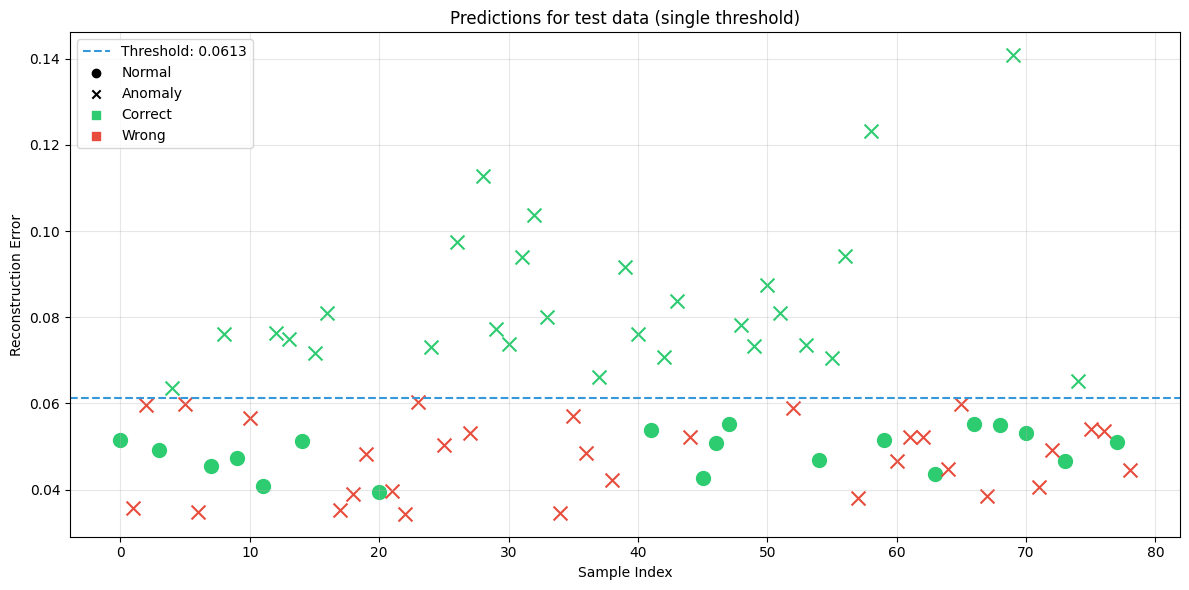

<module 'matplotlib.pyplot' from '/home/sonne/Kode/Universitet/3.Semester/Anomaly-Detection/venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [101]:
anomaly_threshold = get_anomaly_value(test_loader, device=device)
print(f" Reconstruction error threshold = {anomaly_threshold}")
all_images, p, t, r = get_predictions(test_loader, anomaly_threshold, device, True)
print(f"Accuracy = {np.mean(p == t)}")

plot_anomaly_scores(r, t, anomaly_threshold, title="Predictions for test data (single threshold)")

In [102]:
def get_adaptive_thresholds(loader, device="cpu", sigma=1.0):
    model.eval()
    normal_errors = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed = get_reconstruction_from_pretrained(images)
            
            for i, r, l in zip(images, reconstructed, labels):
                if l == 1:
                    error = torch.nn.MSELoss()(r, i)
                    normal_errors.append(error.cpu().numpy())
    
    normal_errors = np.array(normal_errors)
    mean_error = np.mean(normal_errors)
    std_error = np.std(normal_errors)
    
    lower_threshold = mean_error - sigma * std_error
    upper_threshold = mean_error + sigma * std_error
    
    return lower_threshold, upper_threshold

def get_predictions_double_threshold(loader, lower_thresh, upper_thresh, device="cpu"):
    predictions = []
    true_labels = []
    errors = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed = get_reconstruction_from_pretrained(images)
            
            for i, r, l in zip(images, reconstructed, labels):
                error = torch.nn.MSELoss()(r, i)
                error = error.cpu().numpy()
                errors.append(error)
                
                # normal if error is between thresholds
                pred = (lower_thresh <= error <= upper_thresh).astype(float)
                predictions.append(pred)
                true_labels.append(l.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels), np.array(errors)

In [103]:
def plot_double_threshold_scores(errors, labels, lower_t, upper_t, figsize=(12, 6), title="Anomaly Scores w/ Double Threshold"):
    plt.figure(figsize=figsize)
    
    errors = np.array(errors)
    labels = np.array(labels)
    predictions = (lower_t <= errors) & (errors <= upper_t)
    
    for idx, (error, label, pred) in enumerate(zip(errors, labels, predictions)):
        marker = "o" if label == 1 else "x"
        color = "#2ecc71" if label == pred else "#e74c3c"
        plt.scatter(idx, error, c=color, marker=marker, s=100)
    
    plt.axhline(y=upper_t, color="#3498db", linestyle="--", 
                label=f"Upper Bound: {upper_t:.4f}")
    plt.axhline(y=lower_t, color="#3498db", linestyle="--", 
                label=f"Lower Bound: {lower_t:.4f}")
    plt.axhspan(lower_t, upper_t, color="#3498db", alpha=0.1)
    
    plt.grid(True, alpha=0.3)
    plt.xlabel("Sample Index")
    plt.ylabel("Reconstruction Error")
    plt.title(f"{title}")
    
    plt.scatter([], [], c="k", marker="o", label="Normal")
    plt.scatter([], [], c="k", marker="x", label="Anomaly")
    plt.scatter([], [], c="#2ecc71", marker="s", label="Correct")
    plt.scatter([], [], c="#e74c3c", marker="s", label="Wrong")
    plt.legend()
    
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/home/sonne/Kode/Universitet/3.Semester/Anomaly-Detection/venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

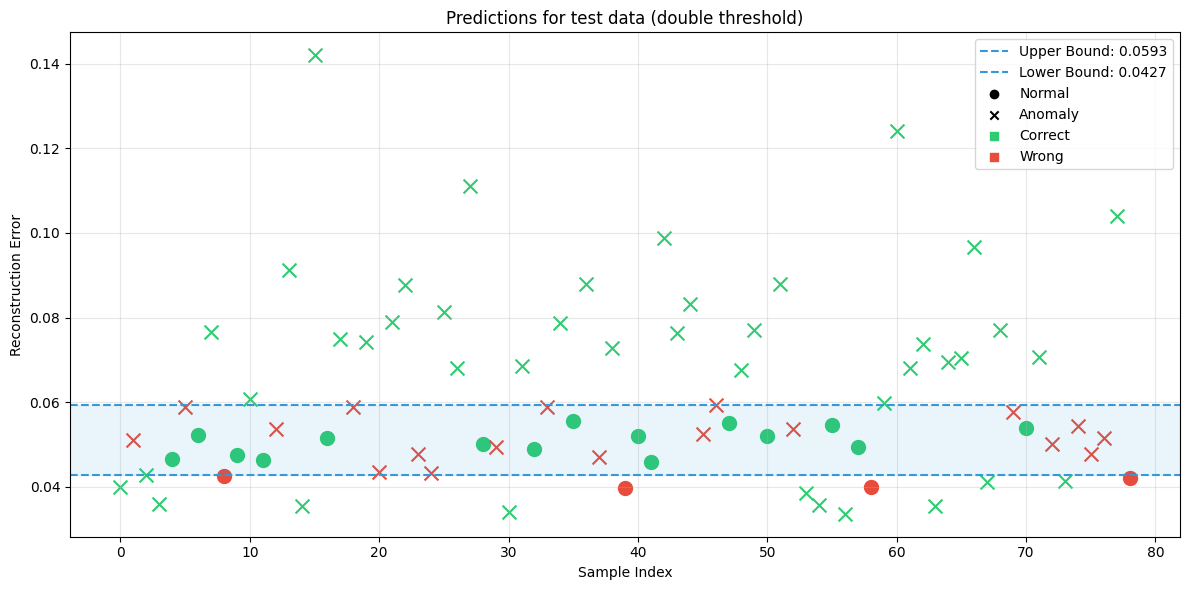

In [104]:
lower_t, upper_t = get_adaptive_thresholds(train_loader, device, sigma=0.5)
p_double, t_double, r_double = get_predictions_double_threshold(test_loader, lower_t, upper_t, device)

# lower_t = 0.26
# upper_t = 0.30

plot_double_threshold_scores(r_double, t_double, lower_t, upper_t, title="Predictions for test data (double threshold)")

In [105]:
def print_metrics(predictions, targets, name=""):
    # Calculate stuffs
    tp = np.sum((predictions == 1) & (targets == 1))
    tn = np.sum((predictions == 0) & (targets == 0))
    fp = np.sum((predictions == 1) & (targets == 0))
    fn = np.sum((predictions == 0) & (targets == 1))
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\nMetrics for {name}:")
    print("Confusion Matrix:")
    print(f"[[{tn}, {fp}],")
    print(f" [{fn}, {tp}]]")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [106]:
print_metrics(p,t,"Single Threshold on Complete Test Data")
print_metrics(p_double,t_double,"Double Threshold on Complete Test Data")


Metrics for Single Threshold on Complete Test Data:
Confusion Matrix:
[[29, 31],
 [0, 19]]
Accuracy: 0.6076
Precision: 0.3800
Recall: 1.0000
F1 Score: 0.5507

Metrics for Double Threshold on Complete Test Data:
Confusion Matrix:
[[42, 18],
 [4, 15]]
Accuracy: 0.7215
Precision: 0.4545
Recall: 0.7895
F1 Score: 0.5769


In [107]:
# Seperate datasets, so we can get the same statistics as bergmann got in his paper
# train_loader only contains non-anomaly images

class AnomalousMVTecDataset(Dataset):
    def __init__(self, root_dir, transform):
        """
        Args:
            root_dir (str): Root directory of MVTec AD dataset
            category (str): Category name (e.g., "bottle", "cable", etc.)
            is_train (bool): If True, load training data, else test data
            transform: transform to be applied on images
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        
        # Get all subfolders EXCEPT the good one
        test_path = os.path.join(root_dir, "test")
        subfolders = [f.path for f in os.scandir(test_path) if f.is_dir()]
        for folder in subfolders:
            if not folder.endswith("good"):
                self.image_paths.extend(self._get_image_paths(os.path.join("test", os.path.basename(folder))))
            
    def _get_image_paths(self, subset):
        path = os.path.join(self.root_dir, subset)
        if not os.path.exists(path):
            return []
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith((".png", ".jpg"))]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        #image = image / 255.0
        # 1 for good; 0 for defect
        label = 1 if "good" in img_path else 0
        return image, label

anomalous_test_dataset = AnomalousMVTecDataset(path, transform)
anomalous_test_loader = DataLoader(anomalous_test_dataset, batch_size=16, shuffle=True)

In [108]:
# Get predictions

# Single threshold
anomalous_all_images_single, p_anomaly_single, t_anomaly_single, r_anomaly_single = get_predictions(anomalous_test_loader, anomaly_threshold, device, True)
allgood_all_images_single, p_allgood_single, t_allgood_single, r_allgood_single = get_predictions(train_loader, anomaly_threshold, device, True)

# Double threshold
p_anomaly_double, t_anomaly_double, r_anomaly_double = get_predictions_double_threshold(anomalous_test_loader, lower_t, upper_t, device)
p_allgood_double, t_allgood_double, r_allgood_double = get_predictions_double_threshold(train_loader, lower_t, upper_t, device)

In [109]:
# Print the mtrics
print_metrics(p_anomaly_single, t_anomaly_single, "Single Threshold on Anomalous Test Data")
print_metrics(p_allgood_single, t_allgood_single, "Single Threshold on non-anomaly Training Data")
print_metrics(p_anomaly_double, t_anomaly_double, "Double Threshold on Anomalous Test Data")
print_metrics(p_allgood_double, t_allgood_double, "Double Threshold on non-anomaly Training")


Metrics for Single Threshold on Anomalous Test Data:
Confusion Matrix:
[[30, 30],
 [0, 0]]
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Single Threshold on non-anomaly Training Data:
Confusion Matrix:
[[0, 0],
 [65, 182]]
Accuracy: 0.7368
Precision: 1.0000
Recall: 0.7368
F1 Score: 0.8485

Metrics for Double Threshold on Anomalous Test Data:
Confusion Matrix:
[[42, 18],
 [0, 0]]
Accuracy: 0.7000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Double Threshold on non-anomaly Training:
Confusion Matrix:
[[0, 0],
 [175, 72]]
Accuracy: 0.2915
Precision: 1.0000
Recall: 0.2915
F1 Score: 0.4514


Single Threshold
Anomalies Only


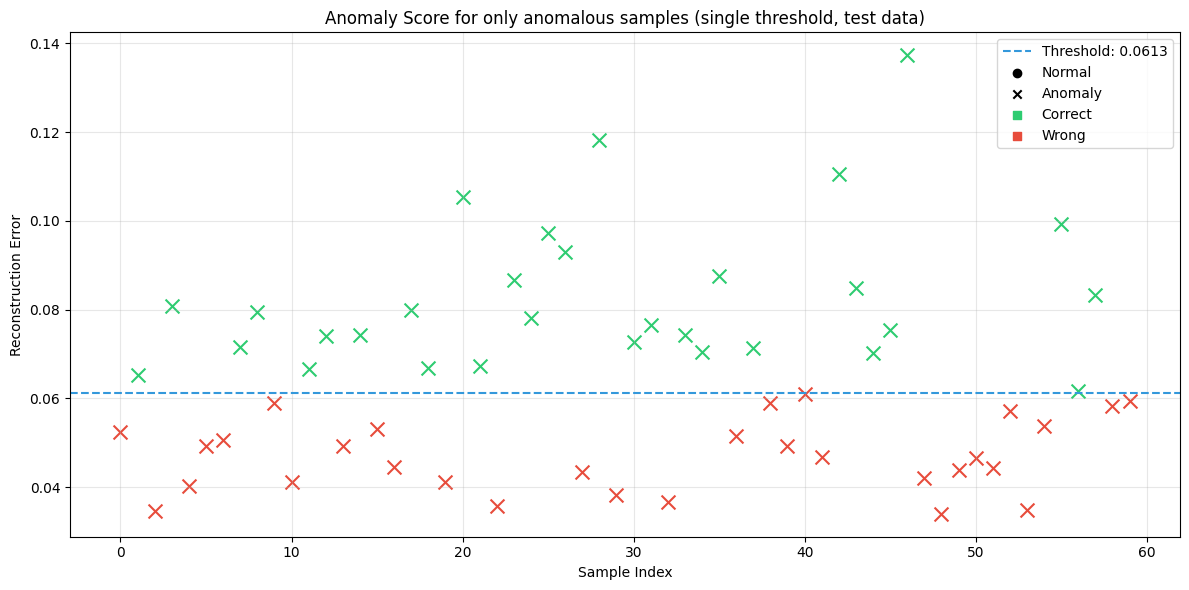

Normal Only


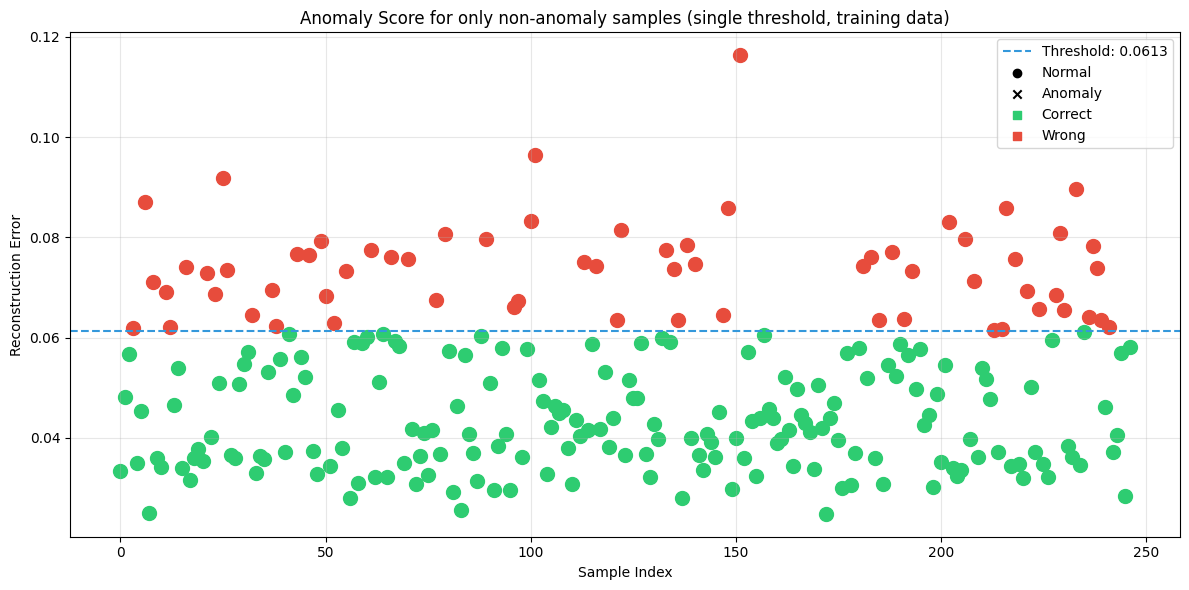

Double Threshold
Anomalies Only
Normal Only


<module 'matplotlib.pyplot' from '/home/sonne/Kode/Universitet/3.Semester/Anomaly-Detection/venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

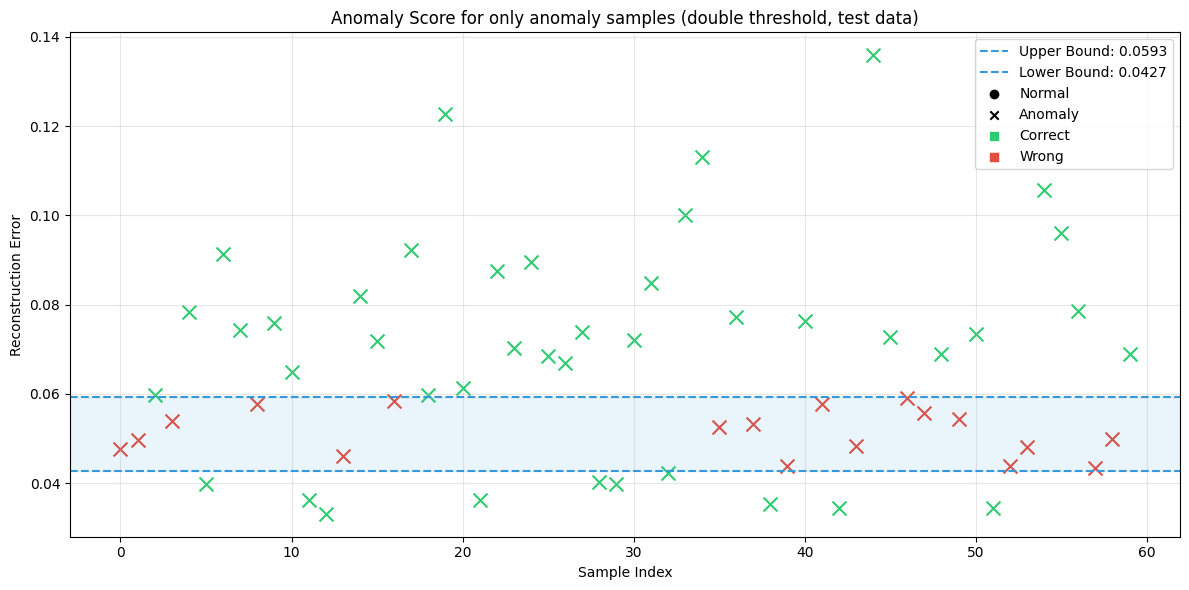

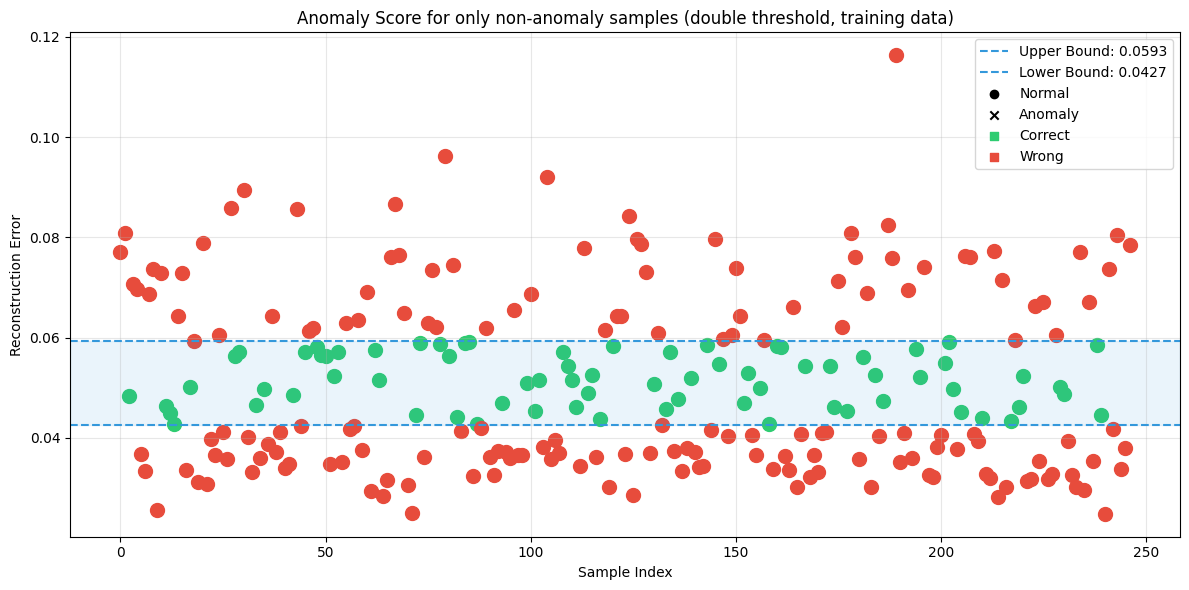

In [118]:
# Plot the points
print("Single Threshold\n=======================================")
print("Anomalies Only")
plot_anomaly_scores(r_anomaly_single, t_anomaly_single, anomaly_threshold, title="Anomaly Score for only anomalous samples (single threshold, test data)")
print("Normal Only")
plot_anomaly_scores(r_allgood_single, t_allgood_single, anomaly_threshold, title="Anomaly Score for only non-anomaly samples (single threshold, training data)")

print("Double Threshold\n=======================================")
print("Anomalies Only")
plot_double_threshold_scores(r_anomaly_double, t_anomaly_double, lower_t, upper_t, title="Anomaly Score for only anomaly samples (double threshold, test data)")
print("Normal Only")
plot_double_threshold_scores(r_allgood_double, t_allgood_double, lower_t, upper_t, title="Anomaly Score for only non-anomaly samples (double threshold, training data)")

<module 'matplotlib.pyplot' from '/home/sonne/Kode/Universitet/3.Semester/Anomaly-Detection/venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

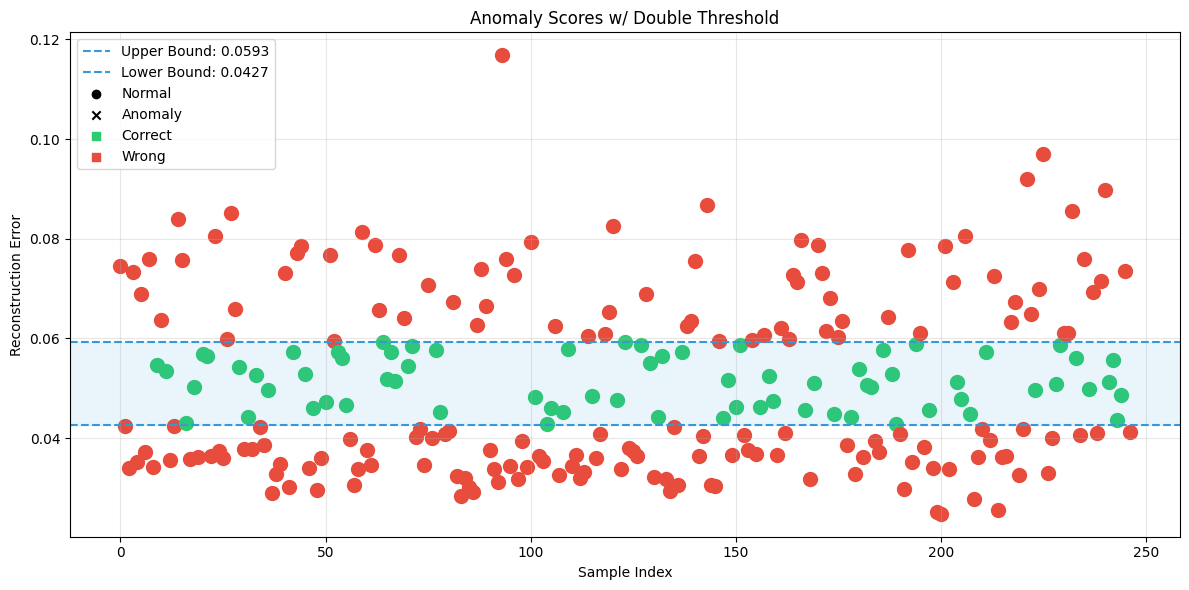

In [111]:
lower_t_newtest, upper_t_newtest = get_adaptive_thresholds(train_loader, device, sigma=0.5)
p_double_newtest, t_double_newtest, r_double_newtest = get_predictions_double_threshold(train_loader, lower_t_newtest, upper_t_newtest, device)
plot_double_threshold_scores(r_double_newtest, t_double_newtest, lower_t_newtest, upper_t_newtest)

In [112]:
# Using probabiliy threshold


# taken from the other notebook
def find_optimal_threshold(model, good_loader, anomaly_loader, device='cuda', num_bins=50, visualization_path=None):
    """
    Analyze reconstruction error distributions and find optimal threshold.
    """
    model.to(device)
    model.eval()
    good_errors = []
    anomaly_errors = []
    
    # Calculate reconstruction errors for good samples
    with torch.no_grad():
        for images, _ in good_loader:
            images = images.to(device)
            reconstructed = get_reconstruction_from_pretrained_tensor(images)
            reconstructed = reconstructed.to(device)
            
            for img, rec in zip(images, reconstructed):
                error = torch.nn.MSELoss()(rec, img)
                good_errors.append(error.cpu().numpy())
    
    # Calculate reconstruction errors for anomaly samples
    with torch.no_grad():
        for images, _ in anomaly_loader:
            images = images.to(device)
            reconstructed = get_reconstruction_from_pretrained_tensor(images)
            reconstructed = reconstructed.to(device)
            
            for img, rec in zip(images, reconstructed):
                error = torch.nn.MSELoss()(rec, img)
                anomaly_errors.append(error.cpu().numpy())
    
    good_errors = np.array(good_errors)
    anomaly_errors = np.array(anomaly_errors)
    
    # Fit normal distributions to both sets of errors
    good_mean, good_std = stats.norm.fit(good_errors)
    anomaly_mean, anomaly_std = stats.norm.fit(anomaly_errors)
    
    # Create points for plotting the fitted normal distributions
    x = np.linspace(min(good_errors.min(), anomaly_errors.min()),
                    max(good_errors.max(), anomaly_errors.max()),
                    1000)
    good_dist = stats.norm.pdf(x, good_mean, good_std)
    anomaly_dist = stats.norm.pdf(x, anomaly_mean, anomaly_std)
    
    # Find intersection point(s)
    y_diff = good_dist - anomaly_dist
    intersection_indices = np.where(np.diff(np.signbit(y_diff)))[0]
    
    if len(intersection_indices) > 0:
        # If distributions intersect, use the intersection point as threshold
        optimal_threshold = x[intersection_indices[0]]
    else:
        # If no intersection, use midpoint between means
        optimal_threshold = (good_mean + anomaly_mean) / 2
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    # Plot histograms
    plt.hist(good_errors, bins=num_bins, density=True, alpha=0.6, color='green', 
             label='Good Samples')
    plt.hist(anomaly_errors, bins=num_bins, density=True, alpha=0.6, color='red',
             label='Anomaly Samples')
    
    # Plot fitted distributions
    plt.plot(x, good_dist, 'g-', lw=2, label='Good Samples (fitted)')
    plt.plot(x, anomaly_dist, 'r-', lw=2, label='Anomaly Samples (fitted)')
    
    # Plot threshold
    plt.axvline(x=optimal_threshold, color='blue', linestyle='--', 
                label=f'Threshold: {optimal_threshold:.6f}')
    
    plt.title('Reconstruction Error Distributions')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add distribution statistics as text
    stats_text = (f'Good samples: μ={good_mean:.6f}, σ={good_std:.6f}\n'
                 f'Anomaly samples: μ={anomaly_mean:.6f}, σ={anomaly_std:.6f}')
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    if visualization_path:
        plt.savefig(visualization_path)
        plt.close()
    else:
        plt.show()
    
    return optimal_threshold, good_errors, anomaly_errors

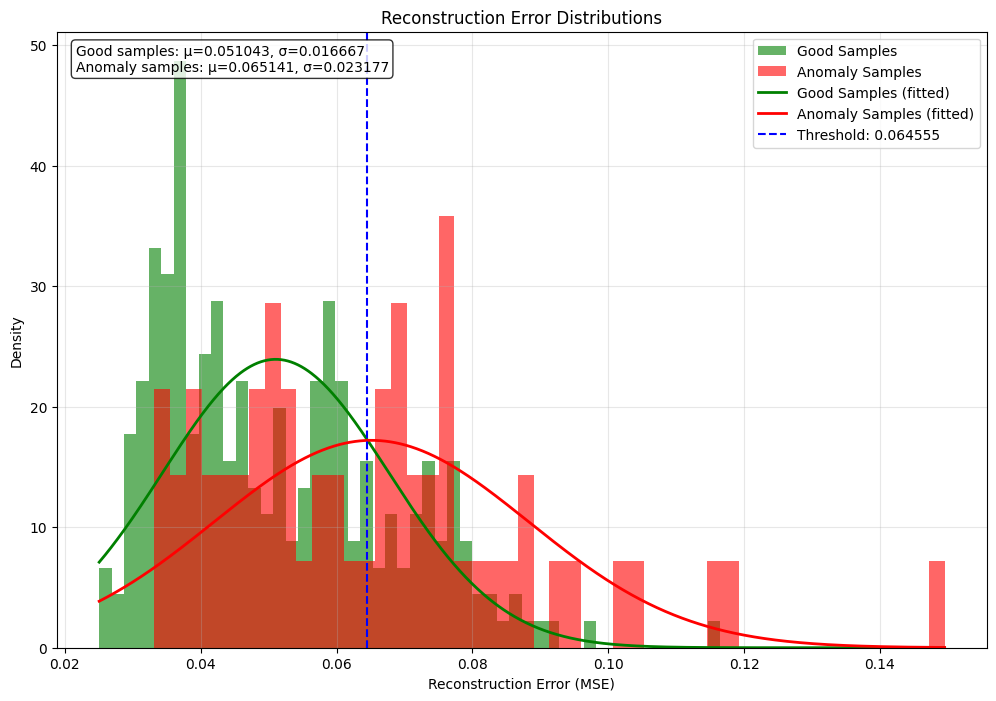

In [113]:
threshold, good_errors, anomaly_errors = find_optimal_threshold(
    model,
    train_loader,
    anomalous_test_loader,
    device='cuda',
    num_bins=50
)

In [114]:
def print_threshold_stats(good_errors, anomaly_errors, threshold):
    """
    Print statistics about the threshold's effectiveness.
    """
    # Calculate true positives, false positives, etc.
    true_negatives = np.sum(good_errors <= threshold)
    false_positives = np.sum(good_errors > threshold)
    true_positives = np.sum(anomaly_errors > threshold)
    false_negatives = np.sum(anomaly_errors <= threshold)
    
    # Calculate metrics
    good_accuracy = true_negatives / len(good_errors) * 100
    anomaly_accuracy = true_positives / len(anomaly_errors) * 100
    overall_accuracy = (true_positives + true_negatives) / (len(good_errors) + len(anomaly_errors)) * 100
    
    print(f"\nThreshold Statistics:")
    print(f"Threshold value: {threshold:.6f}")
    print(f"\nGood samples correctly classified: {good_accuracy:.2f}%")
    print(f"Anomaly samples correctly classified: {anomaly_accuracy:.2f}%")
    print(f"Overall accuracy: {overall_accuracy:.2f}%")
    print(f"\nConfusion Matrix:")
    print(f"True Negatives (Good classified as Good): {true_negatives}")
    print(f"False Positives (Good classified as Anomaly): {false_positives}")
    print(f"True Positives (Anomaly classified as Anomaly): {true_positives}")
    print(f"False Negatives (Anomaly classified as Good): {false_negatives}")
    
print_threshold_stats(good_errors, anomaly_errors, threshold)


Threshold Statistics:
Threshold value: 0.064555

Good samples correctly classified: 79.35%
Anomaly samples correctly classified: 48.33%
Overall accuracy: 73.29%

Confusion Matrix:
True Negatives (Good classified as Good): 196
False Positives (Good classified as Anomaly): 51
True Positives (Anomaly classified as Anomaly): 29
False Negatives (Anomaly classified as Good): 31


In [115]:
# Get predictions
anomalous_all_images_prob, p_anomaly_prob, t_anomaly_prob, r_anomaly_prob = get_predictions(anomalous_test_loader, threshold, device, True)
allgood_all_images_prob, p_allgood_prob, t_allgood_prob, r_allgood_prob = get_predictions(train_loader, threshold, device, True)

In [116]:
print_metrics(p_anomaly_prob, t_anomaly_prob, "Probablility Threshold on Anomalous Test Data")
print_metrics(p_allgood_prob, t_allgood_prob, "Probablility Threshold on non-anomaly Train Data")


Metrics for Probablility Threshold on Anomalous Test Data:
Confusion Matrix:
[[29, 31],
 [0, 0]]
Accuracy: 0.4833
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Metrics for Probablility Threshold on non-anomaly Train Data:
Confusion Matrix:
[[0, 0],
 [51, 196]]
Accuracy: 0.7935
Precision: 1.0000
Recall: 0.7935
F1 Score: 0.8849


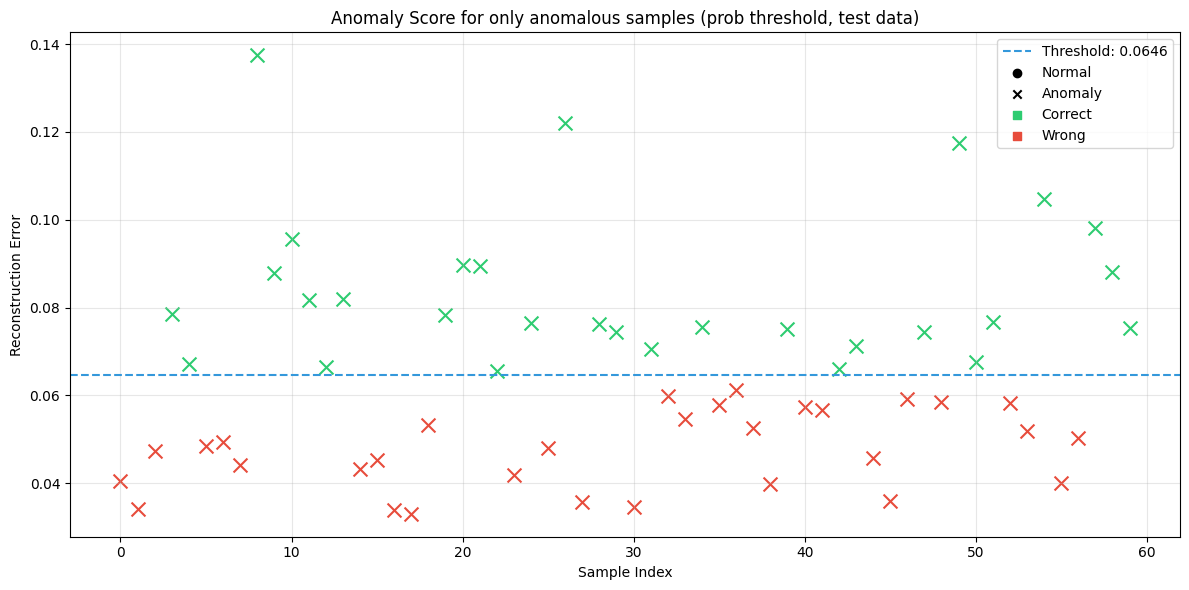

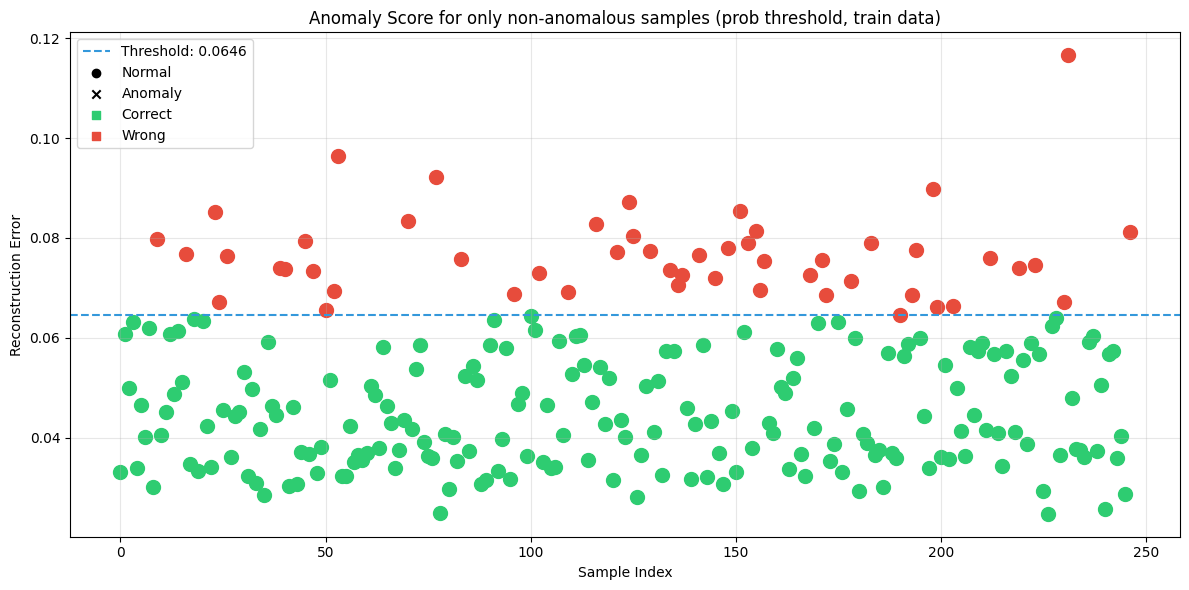

<module 'matplotlib.pyplot' from '/home/sonne/Kode/Universitet/3.Semester/Anomaly-Detection/venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [117]:
plot_anomaly_scores(r_anomaly_prob, t_anomaly_prob, threshold, title="Anomaly Score for only anomalous samples (prob threshold, test data)")
plot_anomaly_scores(r_allgood_prob, t_allgood_prob, threshold, title="Anomaly Score for only non-anomalous samples (prob threshold, train data)")